In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('main.csv')

In [3]:
# df = df.sort_values('Год').reset_index(drop=True)


# df = df.set_index('Год')

# # Создаём новый индекс с шагом 0.25 года 
# full_index = np.arange(df.index.min(), df.index.max() + 0.25, 0.25)
# df = df.reindex(full_index)

# # Интерполируем все числовые значения
# df_interpolated = df.interpolate(method='linear')


# df_interpolated = df_interpolated.reset_index().rename(columns={'index': 'Год'})

# df_interpolated['Год'] = df_interpolated['Год'].round(2)

In [3]:
df_interpolated = df

In [5]:
test_years = df_interpolated['Год'].max() - 1  # последние 2 года

# Делим на train/test
train_df = df_interpolated[df_interpolated['Год'] < test_years].copy()
test_df = df_interpolated[df_interpolated['Год'] >= test_years].copy()

# Разделяем X и y
features = ['Ковид', 'Санкции', 'Ключевая ставка ЦБ РФ (%)', 'Доллар', 'ИПЦ (% к декабрю предыдущего года)', 'Год', 'Район']
target = 'Цена'

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

print(f"🧪 Тренировочная выборка: {X_train.shape[0]} кварталов")
print(f"🧾 Тестовая выборка: {X_test.shape[0]} кварталов")

🧪 Тренировочная выборка: 3048 кварталов
🧾 Тестовая выборка: 254 кварталов


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'R2 Score': r2
    }

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Параметры, которые будем перебирать
param_grid = {
    'n_estimators': [5,10,100, 200, 300, 1000, 10000],
    'max_depth': [2, 3, 4, 5, 15, 100],
    'learning_rate': [0.01, 0.05]
}

# Базовая модель
gbr = GradientBoostingRegressor(random_state=42)

# GridSearch с 5-кратной кросс-валидацией
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Обучаем на тренировочной выборке
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print("🔍 Лучшие параметры:", best_params)

# Лучшая модель
best_gbr = grid_search.best_estimator_

# Предсказание на тесте
y_pred = best_gbr.predict(X_test)

# Оценка

evaluate_model(y_test, y_pred)


Fitting 5 folds for each of 84 candidates, totalling 420 fits
🔍 Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 10000}


{'MAE': 17589.14682746556,
 'MSE': 388551534.26713866,
 'RMSE': np.float64(19711.710587037815),
 'MAPE (%)': np.float64(6.152153986637473),
 'R2 Score': 0.9206543443356174}

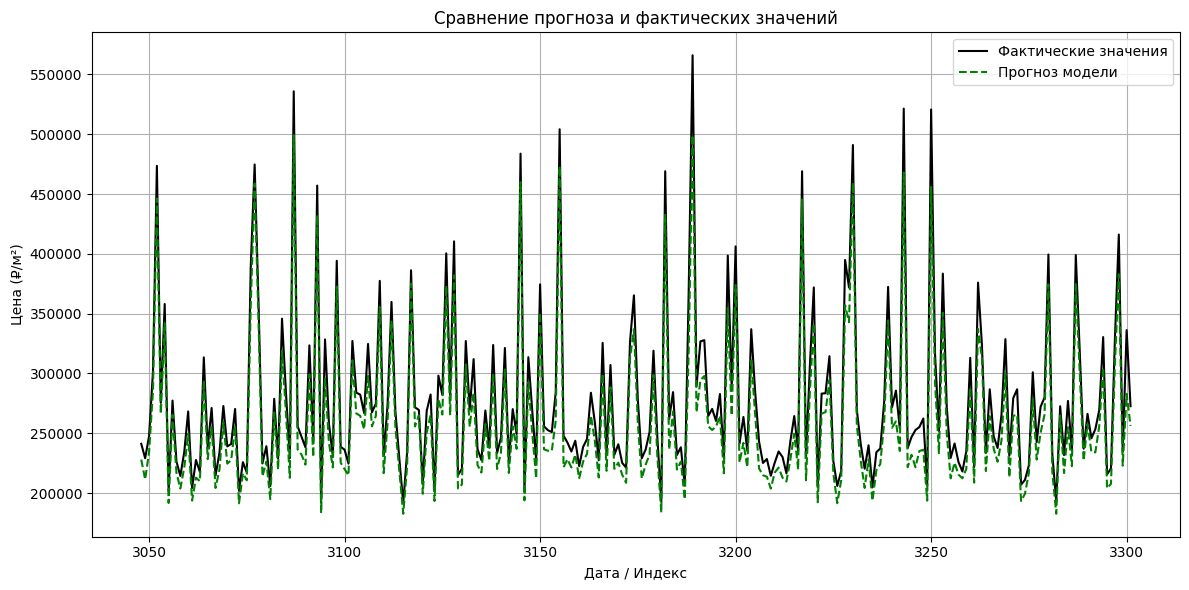

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(y_test.index, y_test.values, label='Фактические значения', color='black')
plt.plot(y_test.index, y_pred, label='Прогноз модели', color='green', linestyle='--')

plt.title('Сравнение прогноза и фактических значений')
plt.xlabel('Дата / Индекс')
plt.ylabel('Цена (₽/м²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
y_pred = best_gbr.predict(df_interpolated[features])

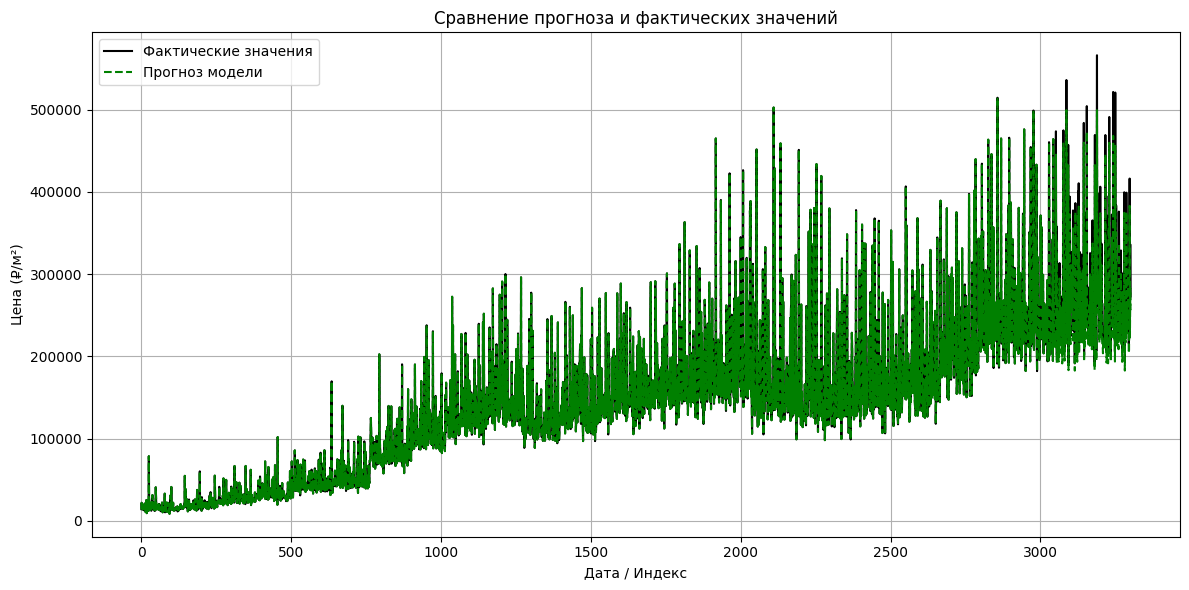

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df_interpolated.index, df_interpolated[target], label='Фактические значения', color='black')
plt.plot(df_interpolated.index, y_pred, label='Прогноз модели', color='green', linestyle='--')

plt.title('Сравнение прогноза и фактических значений')
plt.xlabel('Дата / Индекс')
plt.ylabel('Цена (₽/м²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()